<a href="https://colab.research.google.com/github/sungsushi/msci/blob/main/3d/3d_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate DAG using vectorised numpy methods
# 1+2 dimensions. 


In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
import random 
from google.colab import files
import copy 

from mpl_toolkits.mplot3d import Axes3D


# Generating graph:

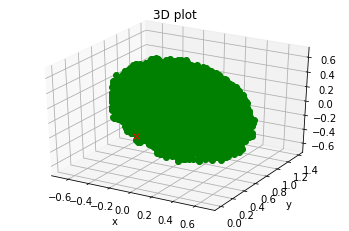

In [ ]:
a= 1/np.sqrt(2)
b=1/np.sqrt(2)
N = 10000

h = a * (np.random.random(N)) ** (1/3)
r = (b / a) * h * np.sqrt(np.random.random(N))
t = 2 * np.pi * np.random.random(N)

#h = a * np.sqrt(np.random.random(N))
#r = (b / a) * h
#t = 2 * np.pi * np.random.random(N)



x = r * np.cos(t)
y = -h + np.sqrt(2)
z = r * np.sin(t)

h2 = a * (np.random.random(N)) ** (1/3)
r2 = (b / a) * h * np.sqrt(np.random.random(N))
t2 = 2 * np.pi * np.random.random(N)

x2 = r * np.cos(t)
y2 = h 
z2 = r * np.sin(t)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(x, y, z, 'go') 
ax.plot3D([0], [0], [0], 'rx') 
plt.xlabel("x")
plt.ylabel("y")

ax.set_title('3D plot') 

plt.show() 



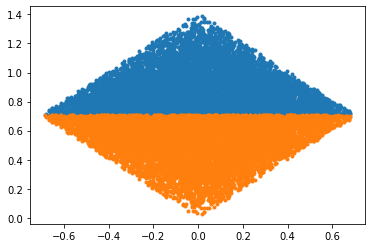

In [ ]:
plt.plot(x,y, '.')
plt.plot(x2,y2, '.')
plt.show()

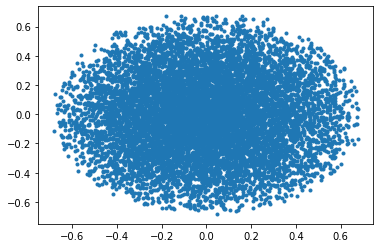

In [ ]:
plt.plot(x2,z2, '.')
plt.show()

In [ ]:
def gen_3dcausal_points(N, seed=None): 
    # N = number of points
    if seed:
        np.random.seed(seed)

    a= 1/np.sqrt(2)
    b=1/np.sqrt(2)
    n = int((N-2)/2)
    h = a * (np.random.random(n) ** (1/3))
    r = (b / a) * h * np.sqrt(np.random.random(n))
    t = 2 * np.pi * np.random.random(n)

    h2 = a * (np.random.random(n) ** (1/3))
    r2 = (b / a) * h2 * np.sqrt(np.random.random(n))
    t2 = 2 * np.pi * np.random.random(n)

    x = r * np.cos(t)
    z = -h + np.sqrt(2)
    y = r * np.sin(t)

    x2 = r2 * np.cos(t)
    z2 = h2 
    y2 = r2 * np.sin(t)

    points = np.array([np.concatenate([x, x2]), np.concatenate([y, y2]), np.concatenate([z, z2])]).T
    #points = np.array([x2,y2,z2]).T

    points = points[points[:,2].argsort()] # sort by ascending in t coordinate (x, y, t)
        
    points = np.insert(points, [0], 0, axis=0) # add the (0,0) node to keep everything causal
    points = np.insert(points, [len(points)], [0, 0, np.sqrt(2)], axis=0) # add the sink node
    return points

## edge connection: 

def spacetime_int_2(v,u):
  #calculate the spacetime interval/proper time between one coord v and vector coords u.
  #assume c = 1
  return -(v[1] - u[:,1])**2 + (v[0] - u[:,0])**2 #vectorised

def adj_list(points):
  # returns an adjacency list
  adj = []
  N = len(points)
  for i in range(N-1): # last node won't be connected to anything
    #print(points[i])
    is_dists_causal = spacetime_int_2(points[i], points[i+1:]) < 0 
    adj.append([i+j+1 for j, e in enumerate(is_dists_causal) if e == True])
  adj.append([])
  return adj

def edges_2(points):
  adj = adj_list(points)
  edges = []
  for i in range(len(adj)):
    for j in adj[i]:
      edges.append((i, j))
  return edges


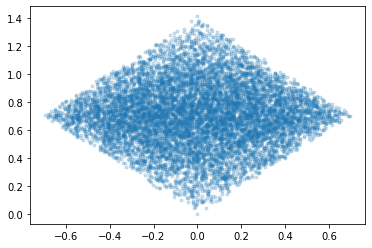

In [ ]:
N = int(10000)
points = gen_3dcausal_points(N, seed = 1) 
x = points[:,0]
y = points[:,1]
z = points[:,2]

plt.plot(x,z, '.', alpha=0.2)

plt.show()

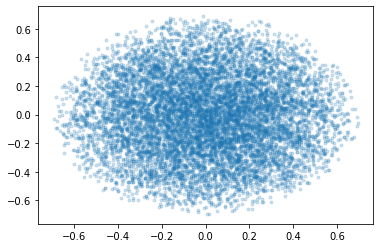

In [ ]:
plt.plot(x,y, '.', alpha=0.2)
plt.show()

# Paths

No need for edge connection

In [ ]:
def random_path_3Dpoints(points, seed=None):
    # points is the coordinates of nodes sorted in time coord
    if seed:
        np.random.seed(seed)
    N = len(points)
    current_node = 0
    path = [0]
    while current_node < N-1:
        #print('current node:', current_node)
        c_node_coord = points[current_node]
        domain = points[current_node + 1:] # all nodes after current_node in time coordinate
        #print('num of points in domain', len(domain))
        #propertimes = np.dot((c_node_coord[:2] - domain[:,:2]), (c_node_coord[:2] - domain[:,:2])) - (c_node_coord[2] - domain[:,2])**2
        propertimes = (c_node_coord[0] - domain[:,0])**2 + (c_node_coord[1] - domain[:,1])**2 - (c_node_coord[2] - domain[:,2])**2
        #print('propertimes of the domain:', propertimes)
        causal = np.where(propertimes < 0)[0] # which indicies of propertimes are causal?
        index = np.random.choice(causal) # choose one of the indices at random
        current_node += 1+ index # new current node
        #print(current_node)
        path.append(current_node) # add the new current node to the path
    
    pathpoints = points[path]
    return pathpoints

def greedy_path_3Dpoints(points):
    # points is the coordinates of nodes sorted in time coord
    path = [0] #start with node zero
    current_node = 0
    N = len(points)
    while current_node < N-1:
        c_node_coord = points[current_node]
        domain = points[current_node + 1:] # all nodes after current_node in time coordinate
        propertimes = (c_node_coord[0] - domain[:,0])**2 + (c_node_coord[1] - domain[:,1])**2 - (c_node_coord[2] - domain[:,2])**2
        causal = np.where(propertimes < 0)[0] # which indicies of propertimes are causal?
        index = min(causal) # choose one of the indices at random
        current_node += 1 + index # new current node
        path.append(current_node) # add the new current node to the path
    pathpoints = points[path]
    return pathpoints

def longest_path_3Dpoints(points): # origin node is taken to be index (and label) 0.
    N = len(points) # N = no. of nodes in the graph
    
    paths = [[] for i in range(N)]
    paths[0].append(0)  # the path lengths of the shortest from the origin node.
    
    for i in range(N):
        c_node_coord = points[i]
        domain = points[i + 1:] # all nodes after current_node in time coordinate
        propertimes = (c_node_coord[0] - domain[:,0])**2 + (c_node_coord[1] - domain[:,1])**2 - (c_node_coord[2] - domain[:,2])**2
        causal = np.where(propertimes < 0)[0] # which indicies of propertimes are causal?
        _list = i + 1 + causal 
        for j in _list: # consider daughter vertices from node i. 
            plength = len(paths[i]) +1
            if plength > len(paths[j]): # if new path is longer than existing path
                paths[j] = paths[i] + [j] # replace old path with the new path
    pathpoints = points[paths[-1]]
    return pathpoints # prints an array of longest paths  whose index corresponds to node label.

def ptgpath_3Dpoints(points):
    # assume points are sorted by its time coordinate
    current_node = 0
    path = [0]
    N = len(points)
    while current_node < N - 1:
        #print(current_node)
        c_node_coord = points[current_node]
        domain = points[current_node + 1:] # all nodes after current_node in time coordinate
        propertimes = (c_node_coord[0] - domain[:,0])**2 + (c_node_coord[1] - domain[:,1])**2 - (c_node_coord[2] - domain[:,2])**2
        invpt = 1/propertimes # inverse pt: numbers near 0 become large in magnitude
        index = np.argmin(invpt) # index of the smallest negative inverse pt (i.e. least negative pt)
        current_node += 1+ index # new current node
        path.append(current_node) # add the new current node to the path
    pathpoints = points[path]
    return pathpoints # array of coordinates in the path


# data taking

In [ ]:
import time
t_0 = time.time()

#Ns = [int(1e1), int(5e1), int(1e2), int(5e2), int(1e3), int(5e3), int(1e4)]
Ns = [int(1e5)]
realisations = int(1)

ptgreedy_path_points = []
tgreedy_path_points = []
r_path_points = []
l_path_points = []



for j in Ns:
    N_ptg_coords = []
    N_tg_coords = []
    N_l_coords = []
    N_r_coords = []
    for i in range(realisations):
        points = gen_3dcausal_points(j, seed= int(i + 1))

        ptgp = ptgpath_3Dpoints(points)
        N_ptg_coords.append(ptgp)

        tgp = greedy_path_3Dpoints(points)
        N_tg_coords.append(tgp)

        rp = random_path_3Dpoints(points, seed=int(i+1))
        N_r_coords.append(rp)

        lp = longest_path_3Dpoints(points)
        N_l_coords.append(lp)

    ptgreedy_path_points.append(N_ptg_coords)
    tgreedy_path_points.append(N_tg_coords)
    r_path_points.append(N_r_coords)
    l_path_points.append(N_l_coords)  


many_paths = np.array([Ns, realisations,  ptgreedy_path_points, tgreedy_path_points, r_path_points, l_path_points], dtype=object)
#file_name = f"{realisations}_3Dpaths.npy"
#np.save(file_name, many_paths, allow_pickle=True)
#files.download(file_name) 

print('time taken = ', time.time() - t_0)



time taken =  432.14822340011597


In [ ]:
# Data loading
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
many_paths = np.load(file='your_path_file_here.npy', allow_pickle=True)

Ns = many_paths[0]
realisations = many_paths[1]
ptgreedy_path_points = many_paths[2]
tgreedy_path_points = many_paths[3]
r_path_points = many_paths[4]
l_path_points = many_paths[5]
print(realisations)

1000
